In [1]:
%matplotlib ipympl

In [24]:
from matplotlib.pyplot import figure, subplots, subplot_mosaic, get_cmap, close
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
from matplotlib.path import Path
from matplotlib.contour import ContourSet
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from numpy import *
from numpy.linalg import *
from numpy.random import *
from numpy.fft import *

In [3]:
from pandas import read_csv, read_excel

In [4]:
from scipy.interpolate import CubicSpline
from scipy.io import whosmat, loadmat

In [5]:
myvars = locals()

# Load data into workspace and perform computations

In [8]:
_load_data = read_excel("../data/Sample data for battery use optimization r3.xlsx")
load_demand = _load_data["Grid_Energy_hrs (kWh)"].to_numpy().sum()/1e3

In [10]:
supply_df = read_csv("../data/gac_sol_1.0mw_supply-curve-aggregation.csv")

In [17]:
df_solarCapEx = read_excel("../data/SolarCapEX.xlsx")
solar_capacity_data = df_solarCapEx["Capacity (MW)"].to_numpy()
solar_cap_cost_data = df_solarCapEx["Solar Capital Cost"].to_numpy()

cs = CubicSpline(solar_capacity_data, solar_cap_cost_data)

In [18]:
df_batteryCapEx = read_excel("../data/BatteryStorageCapEx.xlsx", sheet_name="35 GWh")
battery_capacity_data = df_batteryCapEx["Power (MW)"].to_numpy()
NMC_cap_cost_data = df_batteryCapEx["NMC"].to_numpy()
NCA_cap_cost_data = df_batteryCapEx["NCA"].to_numpy()
LFP_cap_cost_data = df_batteryCapEx["LFP"].to_numpy()

NMC_cs = CubicSpline(battery_capacity_data, NMC_cap_cost_data)
NCA_cs = CubicSpline(battery_capacity_data, NCA_cap_cost_data)
LFP_cs = CubicSpline(battery_capacity_data, LFP_cap_cost_data)

In [19]:
def compute_LCOPR(OCS, PV2GRID, PR, N, E0):
    
    numerator = OCS - PV2GRID*N*PR
    denominator = N*E0

    if E0 == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [20]:
def compute_LCOS(OCS, E_rated, N_EOL):

    numerator = OCS
    denominator = N_EOL*E_rated

    if E_rated == 0.0:
        return 0.0
    else:
        return numerator/denominator

In [21]:
solar_sizes = linspace(0.0, 1000.0, 101)
battery_sizes = linspace(0.0, 100.0, 11)

theoretical_total_cost_NMC = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_NCA = zeros((len(solar_sizes), len(battery_sizes)))
theoretical_total_cost_LFP = zeros((len(solar_sizes), len(battery_sizes)))

duration = 4.0

for i, nameplate_solar_cap in enumerate(solar_sizes[1:]):
    theoretical_total_cost_NMC[i+1, 1:] = cs(nameplate_solar_cap) + NMC_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_NCA[i+1, 1:] = cs(nameplate_solar_cap) + NCA_cs(battery_sizes[1:]/duration)
    theoretical_total_cost_LFP[i+1, 1:] = cs(nameplate_solar_cap) + LFP_cs(battery_sizes[1:]/duration)

max_cost_common = max([theoretical_total_cost_NMC.max(), theoretical_total_cost_NCA.max(), theoretical_total_cost_LFP.max()])

In [22]:
SOLAR, BATTERY = meshgrid(solar_sizes, battery_sizes, indexing="ij")

In [27]:
batt_LCOS = zeros((3, len(battery_sizes)))

rated_duration_h = 4.0

for i, batt_size in enumerate(battery_sizes):
    
    if i == 0:
        continue
        
    batt_LCOS[0, i] = compute_LCOS(OCS=NMC_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size, 
                                   N_EOL=2000)
    batt_LCOS[1, i] = compute_LCOS(OCS=NCA_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,
                                   N_EOL=1400)
    batt_LCOS[2, i] = compute_LCOS(OCS=LFP_cs(batt_size/rated_duration_h), 
                                   E_rated=batt_size,  
                                   N_EOL=6000)

# Figure S9: Capital cost associated with deploying a solar farm of a given nameplate solar capacity

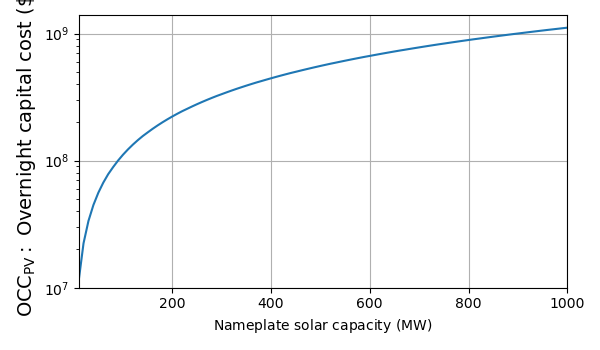

In [29]:
fig, ax = subplots(1, 1, figsize=(6, 3.5))

ax.plot(solar_capacity_data, solar_cap_cost_data)
ax.set_xlabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")
ax.grid(True)
ax.set_yscale("log")
# ax.set_ylabel(r"$\textrm{Solar system}$")
# ax.yaxis.set_label_position("right")

ax.set_ylim((1e7, None))
ax.set_xlim((10, 1000))

ax.set_ylabel(r"$\mathrm{OCC}_{\mathrm{PV}}:\ \mathrm{Overnight\ capital\ cost\ (\$)}$", fontsize=14)

ax.ticklabel_format(axis="x", style="plain")

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS9.pdf")

# Figure S10: Cost of deployment for battery sizes for different chemistries

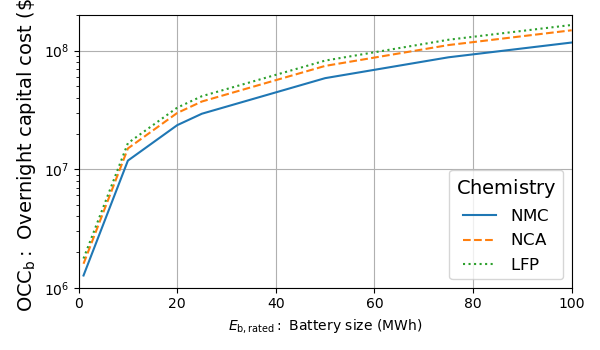

In [30]:
fig, ax = subplots(1, 1, figsize=(6, 3.5))

ax.plot(battery_capacity_data, NMC_cap_cost_data, label=r"$\mathrm{NMC}$")
ax.plot(battery_capacity_data, NCA_cap_cost_data, '--', label=r"$\mathrm{NCA}$")
ax.plot(battery_capacity_data, LFP_cap_cost_data, ':', label=r"$\mathrm{LFP}$")
ax.set_xlabel(r"$E_{\mathrm{b,rated}}:\ \mathrm{Battery\ size\ (MWh)}$")
ax.set_yscale("log")

ax.legend(loc="lower right", prop=dict(size=12), title=r"$\mathrm{Chemistry}$", title_fontsize=14)

ax.grid(True)
ax.set_ylim((1e6, 2e8))
ax.set_xlim((0, 100))

ax.set_ylabel(r"$\mathrm{OCC}_{\mathrm{b}}:\ \mathrm{Overnight\ capital\ cost\ (\$)}$", fontsize=14)

fig.tight_layout()
fig.align_labels()

fig.savefig("../figures/FigS10.pdf")

# Figure S11: Total overnight capital cost (in millions USD) of deploying solar with a given nameplate solar capacity

/var/folders/1j/845hv86j0d314znfz61fnlzm0000gn/T/ipykernel_47303/3819886970.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


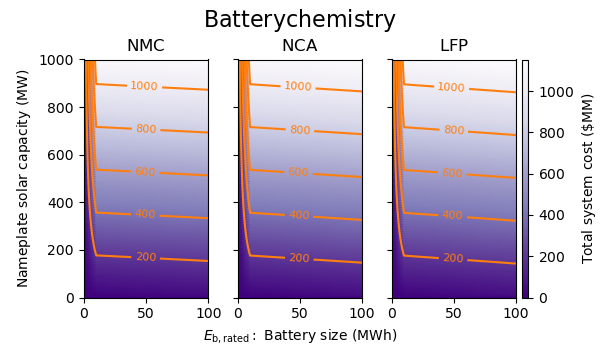

In [26]:
fig, ax = subplots(1, 3, figsize=(6, 3.5), sharex=True, sharey=True)

line_color = "tab:orange"

ax[0].pcolormesh(BATTERY, SOLAR, theoretical_total_cost_NMC/1e6, shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=max_cost_common/1e6)
CS0 = ax[0].contour(BATTERY, SOLAR, theoretical_total_cost_NMC/1e6, array([200, 400, 600, 800, 1000]), colors=line_color, vmin=0.0, vmax=max_cost_common/1e6)
ax[0].clabel(CS0, CS0.levels, inline=True, fontsize=8, manual=[(50, 200), (50, 400), (50, 600), (50, 700), (50, 1000)])
ax[0].set_title(r"$\mathrm{NMC}$")
ax[0].ticklabel_format(style="plain")

ax[1].pcolormesh(BATTERY, SOLAR, theoretical_total_cost_NCA/1e6, shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=max_cost_common/1e6)
CS1 = ax[1].contour(BATTERY, SOLAR, theoretical_total_cost_NCA/1e6, array([200, 400, 600, 800, 1000]), colors=line_color, vmin=0.0, vmax=max_cost_common/1e6)
ax[1].clabel(CS1, CS1.levels, inline=True, fontsize=8, manual=[(50, 200), (50, 400), (50, 600), (50, 700), (50, 1000)])
ax[1].set_title(r"$\mathrm{NCA}$")

ax[2].pcolormesh(BATTERY, SOLAR, theoretical_total_cost_LFP/1e6, shading="gouraud", cmap="Purples_r", vmin=0.0, vmax=max_cost_common/1e6)
CS2 = ax[2].contour(BATTERY, SOLAR, theoretical_total_cost_LFP/1e6, array([200, 400, 600, 800, 1000]), colors=line_color, vmin=0.0, vmax=max_cost_common/1e6)
ax[2].clabel(CS2, CS2.levels, inline=True, fontsize=8, manual=[(50, 200), (50, 400), (50, 600), (50, 700), (50, 1000)])
ax[2].set_title(r"$\mathrm{LFP}$")

cax = fig.add_axes([0.87, 0.15, 0.01, 0.83-0.15])
cbar = fig.colorbar(ScalarMappable(Normalize(vmin=0.0, vmax=max_cost_common/1e6), cmap="Purples_r"), cax=cax)
cbar.set_label(r"$\mathrm{Total\ system\ cost\ (\$ MM)}$")
cbar.ax.yaxis.set_offset_position('left')
formatter = ScalarFormatter(useOffset=False, useMathText=True)
formatter.set_powerlimits((0, 5))
cbar.ax.yaxis.set_major_formatter(formatter)

ax[0].set_ylabel(r"$\mathrm{Nameplate\ solar\ capacity\ (MW)}$")
ax[1].set_xlabel(r"$E_{\mathrm{b,rated}}:\ \mathrm{Battery\ size\ (MWh)}$")

fig.suptitle(r"$\mathrm{Battery\ chemistry}$", fontsize=16)

fig.tight_layout()
fig.align_labels()

fig.subplots_adjust(bottom=0.15, top=0.83, right=0.86)

fig.savefig("../figures/FigS11.pdf")

# Figure S12: Levelized cost of storage for different size battery systems

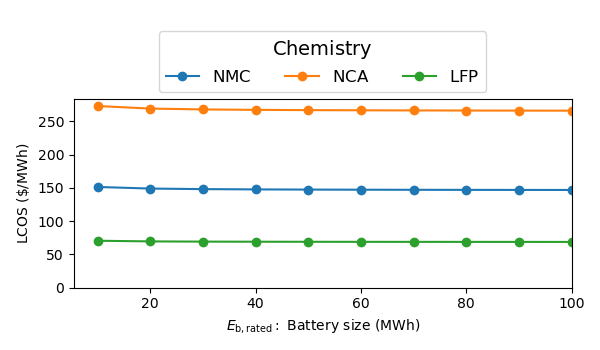

In [28]:
fig, ax = subplots(figsize=(6, 3.5))

ax.plot(battery_sizes[1:], batt_LCOS[0,1:], "o-", ms=6, label=r"$\mathrm{NMC}$")
ax.plot(battery_sizes[1:], batt_LCOS[1,1:], "o-", ms=6, label=r"$\mathrm{NCA}$")
ax.plot(battery_sizes[1:], batt_LCOS[2,1:], "o-", ms=6, label=r"$\mathrm{LFP}$")

ax.legend(loc="center", prop=dict(size=12), ncol=3,
          title=r"$\mathrm{Chemistry}$", title_fontsize=14, 
          bbox_to_anchor=(0.5, 1.2), bbox_transform=ax.transAxes)

ax.set_xlabel(r"$E_{\mathrm{b,rated}}:\ \mathrm{Battery\ size\ (MWh)}$")
ax.set_ylabel(r"$\mathrm{LCOS\ (\$/MWh)}$")

ax.set_ylim((0, None))
ax.set_xlim((None, 100))

fig.tight_layout()

fig.savefig("../figures/FigS12.pdf")